# Reconnaissance d'entités nommées avec SpaCy

La documentation est accessible ici: https://spacy.io/api

## Imports

In [34]:
import os
import re
from collections import Counter, defaultdict
import itertools
import spacy
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [9]:
nlp = spacy.load('fr_core_news_md')

In [3]:
# chargement du corpus
import os

data_path = "../../data/txt_tp4"
files = [f for f in os.listdir(data_path) if f.endswith(".txt")]

corpus_text = ""

for f in files:
    with open(os.path.join(data_path, f), "r", encoding="utf-8") as ff:
        corpus_text += ff.read() + "\n"


In [6]:
# appliquation de Spacy, on traite chaque document individuellementite article par article sinon 
# le corpus est trop grande pour spacy
people = defaultdict(int)
places = defaultdict(int)
orgs = defaultdict(int)

for f in files:
    with open(os.path.join(data_path, f), "r", encoding="utf-8") as ff:
        text = ff.read()

    nlp = spacy.load("fr_core_news_md", disable=["parser", "tagger", "lemmatizer"])


    for ent in doc.ents:
        if ent.label_ == "PER":
            people[ent.text] += 1
        elif ent.label_ == "LOC":
            places[ent.text] += 1
        elif ent.label_ == "ORG":
            orgs[ent.text] += 1



In [7]:
# afficher les 20 entités les plus fréquentes par catégorie
print("PERSONNES les plus citées :")
for p, n in sorted(people.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f" - {p}: {n}")

print("\nLIEUX les plus cités :")
for p, n in sorted(places.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f" - {p}: {n}")

print("\nORGANISATIONS les plus citées :")
for p, n in sorted(orgs.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f" - {p}: {n}")


PERSONNES les plus citées :
 - Beethoven: 5994
 - Feuilleton: 4995
 - Irène: 4995
 - Soames: 4995
 - MHz: 3996
 - Mélodie: 3996
 - Michèle: 3996
 - Forsyte: 2997
 - Messe: 2997
 - Jo: 2997
 - Mozart: 2997
 - Mc: 2997
 - Cavani: 1998
 - Théodorakis: 1998
 - Raoul Walsh: 1998
 - Orgosolo: 1998
 - Tchaïkovsky: 1998
 - Bach: 1998
 - Annette: 1998
 - B.R.T.: 1998

LIEUX les plus cités :
 - Londres: 3996
 - MHz: 3996
 - R.T.B.: 2997
 - B.R.T.: 2997
 - Bruxelles: 2997
 - Vibrato: 2997
 - France: 1998
 - Panoramique: 1998
 - Boers: 1998
 - Barbe-Bleue: 1998
 - Flandres: 1998
 - 98,0 MHz: 1998
 - f t SAMEE: 999
 - ^: 999
 - Participent: 999
 - Autorama: 999
 - Kate’: 999
 - Grande-Bretagne: 999
 - T.F 2: 999
 - Télé-bridge: 999

ORGANISATIONS les plus citées :
 - ALLEMAGNE: 5994
 - LUXEMBOURG: 3996
 - Journal TV: 1998
 - SOTTENS: 1998
 - v''"'C: 999
 - Université populaire: 999
 - Maffia: 999
 - HOLLANDE: 999
 - Avroskoop: 999
 - Tennis Club de Belgiaue: 999
 - O.N.U. T.V.A.: 999
 - Le': 999
 -

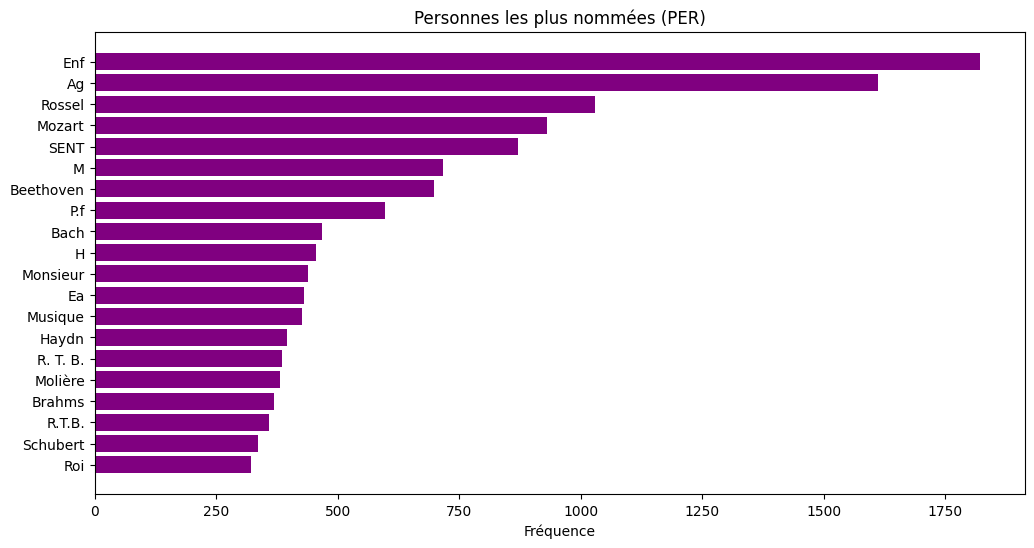

In [8]:
# graphique des personnes les plus citées
import matplotlib.pyplot as plt

def plot_top_dict(dico, title, top=20):
    items = sorted(dico.items(), key=lambda x: x[1], reverse=True)[:top]
    labels, values = zip(*items)

    plt.figure(figsize=(12,6))
    plt.barh(labels, values, color="purple")
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Fréquence")
    plt.show()

# Exemple :
plot_top_dict(people, "Personnes les plus nommées (PER)")


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# mots clés
mots_themes = {"sorcellerie","sorcière","witch","féminisme","femme","procès"}

# construire le réseau
G = nx.Graph()
cooc = defaultdict(int)

for f in files:
    text = open(os.path.join(data_path, f), encoding="utf-8").read()
    doc = nlp(text)
    words = [t.text.lower() for t in doc]

    # vérifier présence mots thématiques
    if any(m in " ".join(words) for m in mots_themes):
        for ent in doc.ents:
            if ent.label_ in {"PER","LOC","ORG"}:
                cooc[ent.text] += 1
                G.add_edge(ent.text, "Thème", weight=1)

# visualisation réseau
plt.figure(figsize=(12,10))
pos = nx.spring_layout(G, k=0.5)

nx.draw(
    G, pos,
    with_labels=True,
    node_size=800,
    node_color="violet",
    edge_color="gray",
    font_size=8
)
plt.title("Graphique de cooccurrences entités ↔ thématique")
plt.show()


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105e93ed0>>
Traceback (most recent call last):
  File "/Users/ilaria/Desktop/STIC/traitement_auto_corpus/tac/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 797, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Traitement des fichiers: 100%|██████████| 999/999 [10:17<00:00,  1.62it/s]

PERSONNES les plus citées :


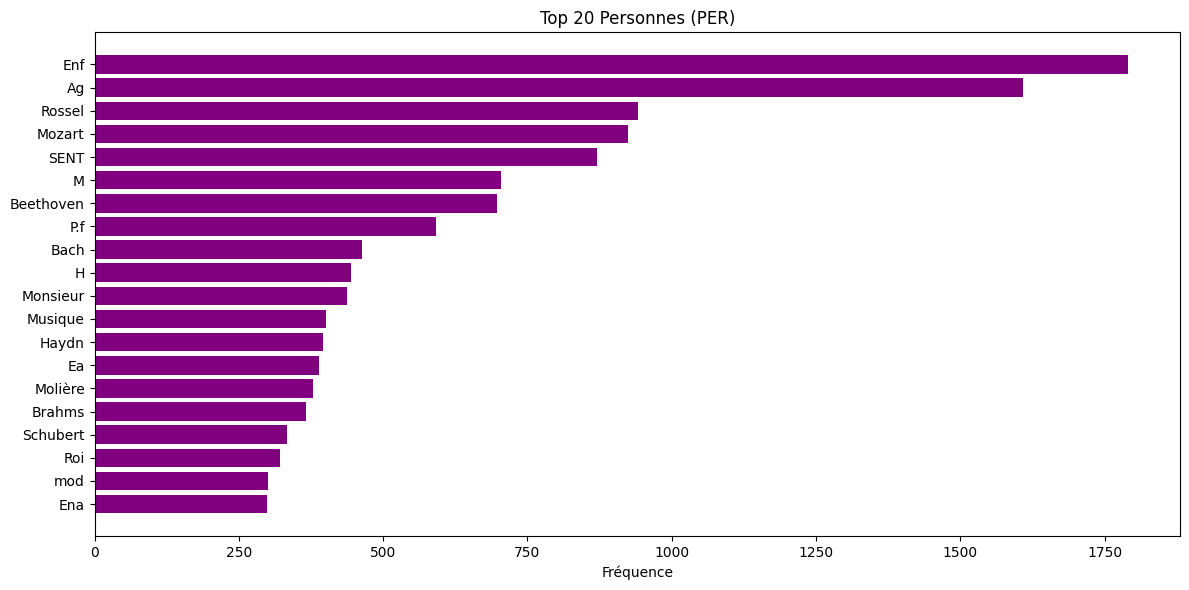


LIEUX les plus cités :


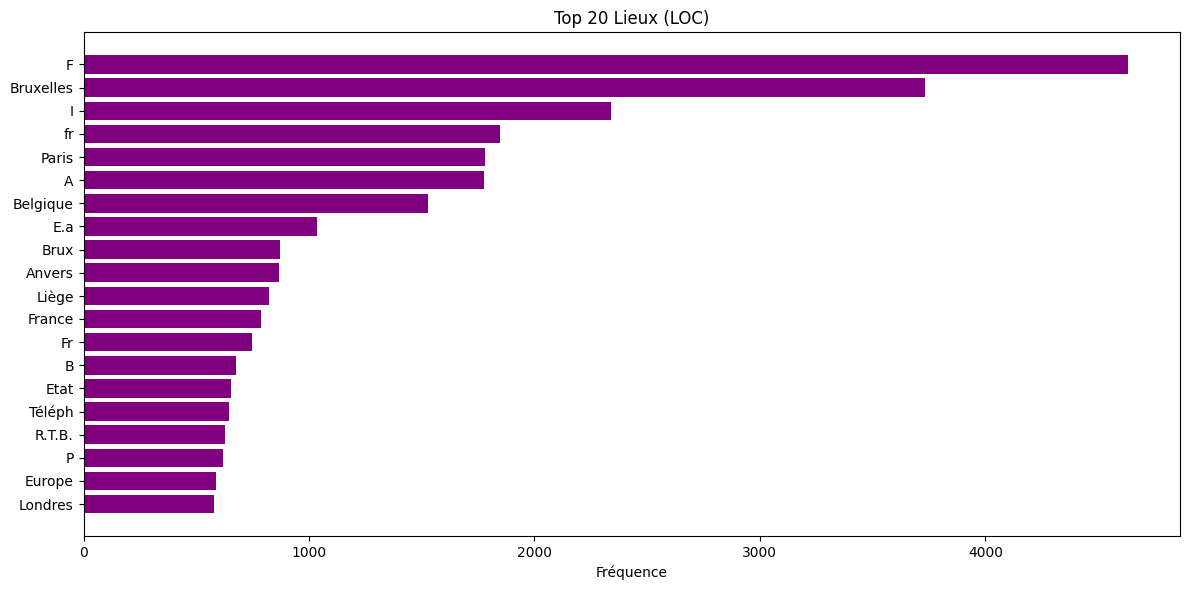


ORGANISATIONS les plus citées :


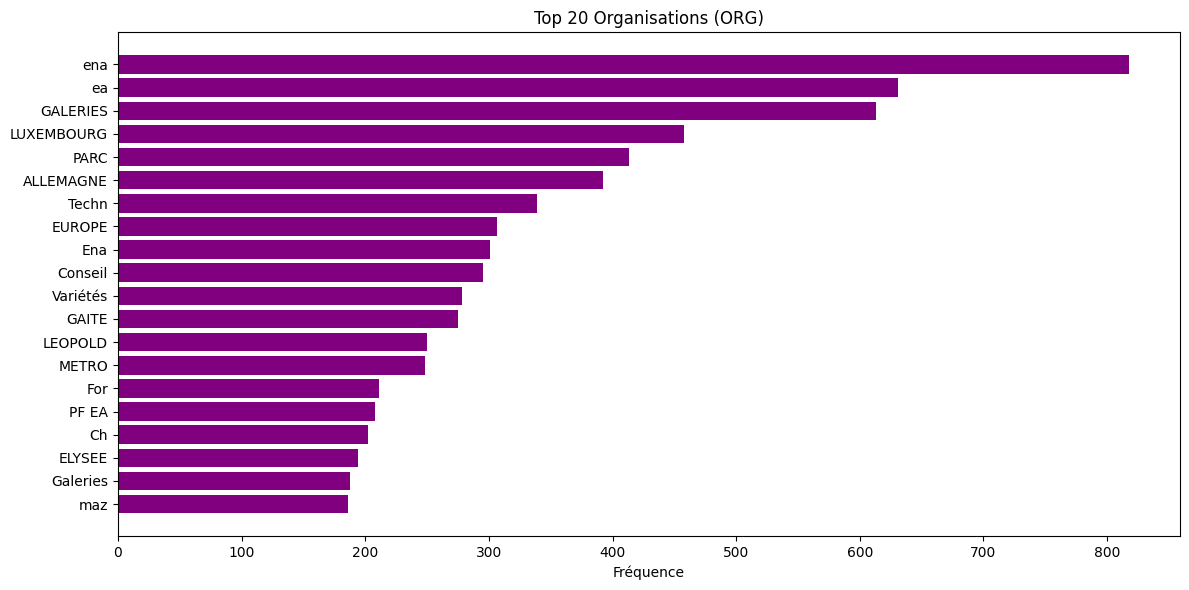

Construction du réseau: 100%|██████████| 999/999 [10:28<00:00,  1.59it/s]


In [ ]:
import os
import re
from collections import Counter, defaultdict
import spacy
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Chargement du modèle spaCy (une seule fois, avec optimisations)
nlp = spacy.load('fr_core_news_md', disable=["parser", "tagger", "lemmatizer"])

# Chemin vers les données
data_path = "../../data/txt_tp4"
files = [f for f in os.listdir(data_path) if f.endswith(".txt")]

# Dictionnaires pour stocker les entités
people = defaultdict(int)
places = defaultdict(int)
orgs = defaultdict(int)

# Expression régulière pour filtrer les entités non pertinentes (ex: "MHz", "B.R.T.")
entity_clean_pattern = re.compile(r'^\d+,\d+\s?MHz$|^[A-Z]{2,3}\.?$|^[\d\W]+$')

# Traitement des fichiers
for f in tqdm(files, desc="Traitement des fichiers"):
    with open(os.path.join(data_path, f), "r", encoding="utf-8") as ff:
        text = ff.read()
        doc = nlp(text)  # Analyse avec spaCy

        for ent in doc.ents:
            # Filtre des entités non pertinentes
            if entity_clean_pattern.search(ent.text):
                continue

            if ent.label_ == "PER":
                people[ent.text] += 1
            elif ent.label_ == "LOC":
                places[ent.text] += 1
            elif ent.label_ == "ORG":
                orgs[ent.text] += 1

# Fonction pour afficher les top entités
def plot_top_entities(entities_dict, title, top=20):
    items = sorted(entities_dict.items(), key=lambda x: x[1], reverse=True)[:top]
    labels, values = zip(*items)

    plt.figure(figsize=(12, 6))
    plt.barh(labels, values, color="purple")
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Fréquence")
    plt.tight_layout()
    plt.show()

# Affichage des résultats
print("PERSONNES les plus citées :")
plot_top_entities(people, "Top 20 Personnes (PER)")

print("\nLIEUX les plus cités :")
plot_top_entities(places, "Top 20 Lieux (LOC)")

print("\nORGANISATIONS les plus citées :")
plot_top_entities(orgs, "Top 20 Organisations (ORG)")

# -------------------------------------------------------------------
# Partie 2 : Réseau de cooccurrences avec mots-clés thématiques
# -------------------------------------------------------------------
mots_themes = {"sorcellerie", "sorcière", "witch", "féminisme", "femme", "procès"}

# Graphique de cooccurrences
G = nx.Graph()
cooc = defaultdict(int)

for f in tqdm(files, desc="Construction du réseau"):
    with open(os.path.join(data_path, f), "r", encoding="utf-8") as ff:
        text = ff.read()
        doc = nlp(text)
        words = [t.text.lower() for t in doc]

        # Vérification de la présence de mots thématiques
        if any(mot in words for mot in mots_themes):
            for ent in doc.ents:
                if ent.label_ in {"PER", "LOC", "ORG"}:
                    if not entity_clean_pattern.search(ent.text):  # Filtre
                        cooc[ent.text] += 1
                        G.add_node(ent.text, type=ent.label_)
                        G.add_edge(ent.text, "Thème")

# Visualisation du réseau
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.5, seed=42)  # seed pour reproductibilité

node_colors = []
for node in G.nodes():
    if node == "Thème":
        node_colors.append("red")
    else:
        node_colors.append("violet")

nx.draw(
    G, pos,
    with_labels=True,
    node_size=1000,
    node_color=node_colors,
    edge_color="gray",
    font_size=10,
    font_weight="bold"
)
plt.title("Réseau de cooccurrences : Entités ↔ Thématique (Sorcellerie/Féminisme)", pad=20)
plt.show()


# Refaire pour essayer 

In [1]:
# Librairies
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from pprint import pprint

# NLTK pour le prétraitement
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Scikit-learn
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilaria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Charger tout le dataset 20 Newsgroups
news = fetch_20newsgroups(subset='all')
texts = news.data
labels = news.target_names
targets = np.array([labels[t] for t in news.target])

print(f"Nombre d'articles : {len(texts)}")
print(f"Nombre de catégories : {len(labels)}")


Nombre d'articles : 18846
Nombre de catégories : 20


In [3]:
for i, article in enumerate(texts[:3]):
    print(f"===== {labels[news.target[i]]} =====")
    print(article.replace('\n', ' '), "\n")


===== rec.sport.hockey =====
From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu> Subject: Pens fans reactions Organization: Post Office, Carnegie Mellon, Pittsburgh, PA Lines: 12 NNTP-Posting-Host: po4.andrew.cmu.edu    I am sure some bashers of Pens fans are pretty confused about the lack of any kind of posts about the recent Pens massacre of the Devils. Actually, I am  bit puzzled too and a bit relieved. However, I am going to put an end to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they are killing those Devils worse than I thought. Jagr just showed you why he is much better than his regular season stats. He is also a lot fo fun to watch in the playoffs. Bowman should let JAgr have a lot of fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final regular season game.          PENS RULE!!!   

===== comp.sys.ibm.pc.hardware =====
From: mblawson@midway.ecn.uok

In [4]:
clean_texts = [re.sub('[^a-z]+', ' ', t.lower()).strip() for t in texts]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    clean_texts, targets, test_size=0.2, random_state=11
)

print("Taille du training set:", len(X_train))
print("Taille du test set:", len(X_test))


Taille du training set: 15076
Taille du test set: 3770


In [6]:
classifier = Pipeline([
    ('vectorizer', TfidfVectorizer(
        stop_words=stopwords.words('english'),
        min_df=50,  # ignorer les mots très rares
        max_df=0.5  # ignorer les mots très fréquents
    )),
    ('classifier', MultinomialNB())
])

# Entrainement du modèle
classifier.fit(X_train, y_train)


,steps,"[('vectorizer', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [7]:
feature_names = classifier.named_steps['vectorizer'].get_feature_names_out()
idf_scores = classifier.named_steps['vectorizer'].idf_

print(f"Taille du vocabulaire : {len(feature_names)}")

# Quelques scores IDF
for i in range(10):
    print(feature_names[i], ":", round(idf_scores[i], 2))

# Les 10 mots avec IDF le plus haut
top_words = sorted(zip(feature_names, idf_scores), key=operator.itemgetter(1), reverse=True)[:10]
print("\nMots avec IDF le plus haut :")
for word, score in top_words:
    print(word, round(score, 2))


Taille du vocabulaire : 5143
aa : 5.43
aaron : 6.07
ab : 5.07
abc : 6.43
abiding : 6.6
ability : 4.99
able : 3.63
abortion : 6.46
absence : 6.46
absolute : 5.62

Mots avec IDF le plus haut :
accomplished 6.69
accord 6.69
acknowledge 6.69
alabama 6.69
approval 6.69
atmospheric 6.69
bach 6.69
bills 6.69
boring 6.69
brunswick 6.69


In [8]:
tmp = classifier.named_steps['vectorizer'].transform(X_train[:10])
pd.DataFrame(tmp.toarray(), columns=feature_names)


,aa,aaron,ab,abc,abiding,ability,able,abortion,absence,absolute,...,za,zealand,zero,zeus,zip,zone,zoo,zoology,zuma,zx
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.174288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Figure size 1500x1500 with 0 Axes>

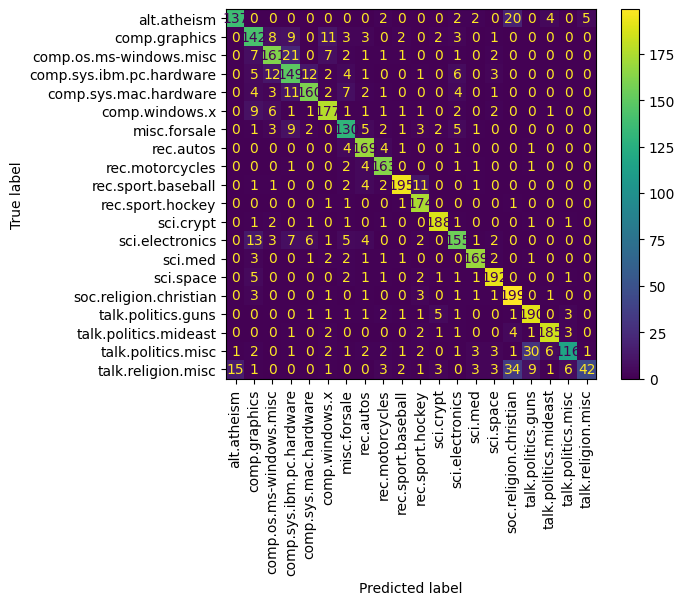

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(15, 15))  # <- définir la taille ici
disp.plot(xticks_rotation='vertical')
plt.show()
